In [25]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation as animation
import csv
import os
import time
from tqdm import tqdm

np.random.seed(1234)

In [26]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA")
else:
    device = torch.device("cpu")
    print("CPU")

# device = torch.device("cpu")

CUDA


In [27]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

In [28]:
lbfgs_lr = 0.01
adam_lr = 0.1

w_pde = 0.1
w_bc = 1.0
w_ic = 1.0

In [44]:
class PINN():
    def __init__(self, X, layers, lb, rb, f, ic1, ic2):
        
        self.x_all = X["all"][0]
        self.t_all = X["all"][1]

        self.x_bc_lb = X["bc_lb"][0]
        self.t_bc_lb = X["bc_lb"][1]
        self.x_bc_rb = X["bc_rb"][0]
        self.t_bc_rb = X["bc_rb"][1]

        self.x_ic = X["ic"][0]
        self.t_ic = X["ic"][0]

        self.f = f
        self.ic1 = ic1
        self.ic2 = ic2

        self.lb = lb
        self.rb = rb

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=1000, gamma=0.5)
        self.iter = 0

    def model_value(self, x, t):
        u = self.dnn(torch.stack([x, t], dim=1))
        return u
    
    def space_derivative(self, u, x):
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        u_3x = torch.autograd.grad(u_2x, x, torch.ones_like(u_2x), create_graph=True)[0]
        u_4x = torch.autograd.grad(u_3x, x, torch.ones_like(u_3x), create_graph=True)[0]      

        return u_x, u_2x, u_3x, u_4x
    
    def time_derivative(self, u , t):
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_2t = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]

        return u_t, u_2t

    def boundary_condition(self, cond, x, t):
        u = self.model_value(x, t)
        bc_loss = 0
        u_x, u_2x, u_3x, _ = self.space_derivative(u, x)

        match cond:
            case 'pinned':
                bc_loss += torch.mean(u**2) + torch.mean(u_2x**2)
            case 'fixed':
                bc_loss += torch.mean(u**2) + torch.mean(u_x**2)
            case 'free':
                bc_loss += torch.mean(u_2x**2) + torch.mean(u_3x**2)
            case 'roller':
                bc_loss += torch.mean(u_x**2) + torch.mean(u_3x**2)

        return bc_loss
    
    def initial_condition(self, x, t):
        u = self.model_value(x, t)
        u_t, _ = self.time_derivative(u, t)

        ic_loss = torch.mean((u - self.ic1)**2)

        ic_loss += torch.mean((u_t - self.ic2)**2)
 
        return ic_loss

    def pde(self, x, t):
        u = self.model_value(x, t)
        _, _, _, u_4x = self.space_derivative(u, x)
        _, u_2t = self.time_derivative(u, t)
        
        pde_loss = torch.mean((u_2t + u_4x - self.f)**2)

        return pde_loss

    def loss_func(self):
        pde_loss = self.pde(self.x_all, self.t_all)
        bc_loss = self.boundary_condition(self.lb, self.x_bc_lb, self.t_bc_lb)
        bc_loss += self.boundary_condition(self.rb, self.x_bc_rb, self.t_bc_rb)
        ic_loss = self.initial_condition(self.x_ic, self.t_ic)

        # total_loss = w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss

        return pde_loss, bc_loss, ic_loss


    def lbfgs_func(self):
        # loss = self.loss_func()
        pde_loss, bc_loss, ic_loss = self.loss_func()
        loss = w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss

        self.optimizer_lbfgs.zero_grad()
        loss.backward(retain_graph=True)

        self.iter += 1
        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
            print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}, IC: {'{:e}'.format(ic_loss.item())}")
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in tqdm(range(epochs)):
            # loss = self.loss_func()
            pde_loss, bc_loss, ic_loss = self.loss_func()
            loss = w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss


            self.optimizer_adam.zero_grad()
            loss.backward(retain_graph=True)
            self.optimizer_adam.step()
            # self.scheduler.step()

            if epoch % 200 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}, IC: {'{:e}'.format(ic_loss.item())}")
                # print(f"Current LR: {self.scheduler.get_last_lr()[0]}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, t):
        self.dnn.eval()
        u = self.model_value(x, t)
        u = u.detach().cpu().numpy()

        # final_loss = self.loss_func()
        # final_loss = final_loss.detach().cpu().numpy()
        return u

In [30]:
def func(x, t):
    return (1-16*np.pi**2) * np.sin(x) * np.cos(4*np.pi*t)

In [31]:
def generate_points(points):
    def ic_points(n_points):
        x = torch.rand(n_points, device=device).requires_grad_()
        t = torch.zeros(n_points, device=device).requires_grad_()
        return x, t

    def bc_points(n_points, x_bc):
        x = torch.ones(n_points, device=device).requires_grad_() * x_bc
        t = torch.rand(n_points, device=device).requires_grad_()
        return x, t

    def domain_points(n_points):
        x = torch.rand(n_points, device=device).requires_grad_()
        t = torch.rand(n_points, device=device).requires_grad_()
        return x, t

    x_d, t_d = domain_points(points[0])
    x_bc_lb, t_bc_lb = bc_points(points[1], 0)
    x_bc_rb, t_bc_rb = bc_points(points[1], torch.pi)
    x_ic, t_ic = ic_points(points[2])

    x_all = torch.cat([x_d, x_bc_lb, x_bc_rb, x_ic], dim=0)
    t_all = torch.cat([t_d, t_bc_lb, t_bc_rb, t_ic], dim=0)


    generated_points = {"all": [x_all, t_all], "bc_lb": [x_bc_lb, t_bc_lb], "bc_rb": [x_bc_rb, t_bc_rb], "ic": [x_ic, t_ic]}
    return generated_points


In [45]:
points = [10000, 2000, 2000]
collocation = generate_points(points)


all_x = collocation["all"][0]
all_t = collocation["all"][1]

ic_x = collocation["ic"][0]

f = lambda x, t: (1 - 16*torch.pi**2)*torch.sin(x)*torch.cos(4*torch.pi*t)
ic1 = lambda x: torch.sin(x)
ic2 = lambda x: torch.full_like(x, 0)

vec1 = ic1(ic_x)
vec2 = ic2(ic_x)
fun = f(all_x, all_t)

In [46]:
nodes = 32
layers = [2, nodes, nodes, nodes, nodes, 1]
lb = 'pinned'
rb = 'pinned'

model = PINN(collocation, layers, lb, rb, fun, vec1, vec2)

In [34]:
num_params = sum(p.numel() for p in model.dnn.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params}")
print(f"Collocation points: {len(collocation["all"][0])}")

Total trainable parameters: 3297
Collocation points: 16000


In [47]:
model.train(0)

0it [00:00, ?it/s]


Iter: 100, Loss: 1.835297e+02
PDE: 1.828280e+03, BC: 5.331139e-01, IC: 1.686209e-01
Iter: 200, Loss: 1.512022e+02
PDE: 1.479689e+03, BC: 4.798138e-01, IC: 2.753452e+00
Iter: 300, Loss: 1.287339e+02
PDE: 1.258248e+03, BC: 1.349880e+00, IC: 1.559193e+00
Iter: 400, Loss: 7.118521e+01
PDE: 6.306570e+02, BC: 3.691945e+00, IC: 4.427563e+00
Iter: 500, Loss: 3.671738e+01
PDE: 2.514108e+02, BC: 6.094519e+00, IC: 5.481780e+00
Iter: 600, Loss: 1.994587e+01
PDE: 1.352961e+02, BC: 4.157126e+00, IC: 2.259134e+00
Iter: 700, Loss: 6.323730e+00
PDE: 2.356041e+01, BC: 1.846097e+00, IC: 2.121591e+00
Iter: 800, Loss: 3.777767e+00
PDE: 1.534617e+01, BC: 1.238243e+00, IC: 1.004907e+00
Iter: 900, Loss: 2.485143e+00
PDE: 1.081562e+01, BC: 9.328381e-01, IC: 4.707427e-01
Iter: 1000, Loss: 1.851343e+00
PDE: 8.300085e+00, BC: 6.625364e-01, IC: 3.587985e-01
Iter: 1100, Loss: 1.398669e+00
PDE: 4.792971e+00, BC: 6.290576e-01, IC: 2.903144e-01
Iter: 1200, Loss: 1.094214e+00
PDE: 2.873105e+00, BC: 5.823018e-01, IC: 2.

In [ ]:

# d = domain_points(2000)
# bc_lb = bc_points(200, 0)
# bc_rb = bc_points(400, 1)
# ic = ic_points(200)

# x1 = d[:, 0].cpu().numpy()
# t1 = d[:, 1].cpu().numpy()

# x2 = bc_lb[:, 0].cpu().numpy()
# t2 = bc_lb[:, 1].cpu().numpy()

# x3 = bc_rb[:, 0].cpu().numpy()
# t3 = bc_rb[:, 1].cpu().numpy()

# x4 = ic[:, 0].cpu().numpy()
# t4 = ic[:, 1].cpu().numpy()

# plt.scatter(x1, t1, s=10, color="blue", alpha=0.5)
# plt.scatter(x2, t2, s=10, color="red", alpha=0.5)
# plt.scatter(x3, t3, s=10, color="red", alpha=0.5)
# plt.scatter(x4, t4, s=10, color="green", alpha=0.5)
# plt.xlabel("x")
# plt.ylabel("t")
# plt.show()


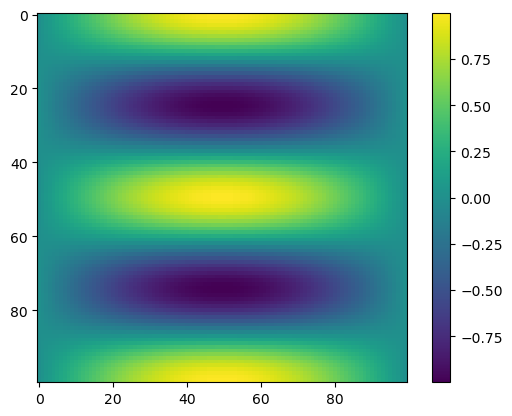

In [48]:

# Exact solution

def exact_solution(x, t):
    return np.sin(x)*np.cos(4*np.pi*t)


x = np.linspace(0, np.pi, 100)
t = np.linspace(0, 1, 100)

X, T = np.meshgrid(x, t)
U = np.sin(X) * np.cos(4 * np.pi * T) 

plt.imshow(U)
plt.colorbar()
plt.show()

# # Set up the figure and axis
# fig, ax = plt.subplots()
# ax.set_xlim(0, np.pi)
# ax.set_ylim(-1, 1)
# ax.set_xlabel("x")
# ax.set_ylabel("u(x, t)")
# ax.set_title("Animation of Exact Solution")


# # Initialize the line object
# line, = ax.plot([], [], lw=2)

# # Initialization function: Clears the line data
# def init():
#     line.set_data([], [])
#     return line,

# # Update function for each frame
# def update(frame):
#     y = exact_solution(x, t[frame])  # Compute solution at current time step
#     line.set_data(x, y)
#     return line,

# # Create the animation
# ani = animation.FuncAnimation(fig, update, frames=len(t), init_func=init, blit=True, interval=50)

# ani.save("wave_animation.gif", writer="pillow", fps=30)

In [ ]:


X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
           

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

print(X_star)
print(lb)
print(ub)

2.3030512
[0.43739316 0.5285883  0.619742   ... 0.06436636 0.03267239 0.00092796]


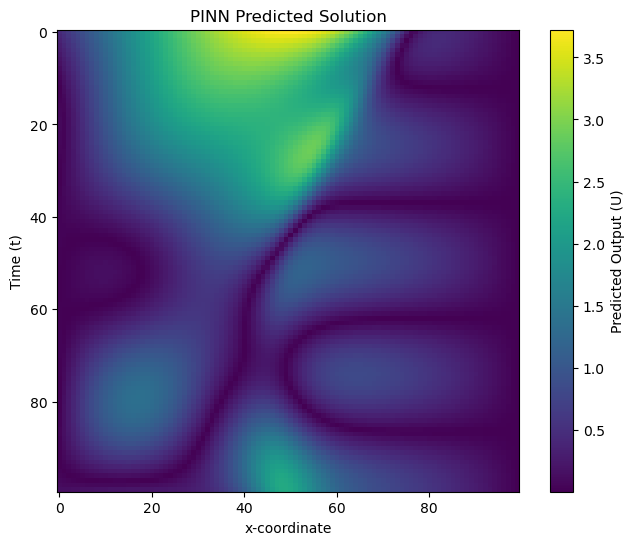

In [60]:
# Define the resolution of the grid
x_min, x_max = 0, np.pi  # X range
t_min, t_max = 0, 1  # Time range
grid_size = 100  # Number of points in each dimension

# Create a meshgrid
x_vals = np.linspace(x_min, x_max, grid_size)
t_vals = np.linspace(t_min, t_max, grid_size)
X, T = np.meshgrid(x_vals, t_vals)  # Create a 2D meshgrid

# Flatten the meshgrid and convert to PyTorch tensor
X_flat = torch.tensor(X.flatten(), dtype=torch.float32, device=device)
T_flat = torch.tensor(T.flatten(), dtype=torch.float32, device=device)

u_exact = torch.sin(X_flat) * torch.cos(4 * torch.pi * T_flat)
u_exact = u_exact.detach().cpu().numpy()
u_pred = model.predict(X_flat, T_flat).flatten()
abs_error = np.abs(u_pred - u_exact)
l2_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact, 2)


# Reshape predictions back into a 2D grid
U_pred_reshaped = u_pred.reshape(grid_size, grid_size)

abs_error_reshape = abs_error.reshape(grid_size, grid_size)

print(l2_error)
print(abs_error)

# Plot the result
plt.figure(figsize=(8, 6))
plt.imshow(abs_error_reshape)
plt.colorbar(label="Predicted Output (U)")
plt.xlabel("x-coordinate")
plt.ylabel("Time (t)")
plt.title("PINN Predicted Solution")
plt.show()